In [3]:
pip install keras-tuner

In [4]:
import tensorflow as tf
import math
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from kerastuner.tuners import RandomSearch
from sklearn.preprocessing import OneHotEncoder

In [5]:
# Load LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [6]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Reshape input data for CNN
X_train = X_train.reshape(X_train.shape[0], h, w, 1)
X_val = X_val.reshape(X_val.shape[0], h, w, 1)
X_test = X_test.reshape(X_test.shape[0], h, w, 1)

num_classes = len(np.unique(y_test))
input_shape = X_train.shape[1:]

In [7]:
# Convert labels to one-hot encoded format
encoder = OneHotEncoder(categories='auto')
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val_onehot = encoder.transform(y_val.reshape(-1, 1)).toarray()
y_test_onehot = encoder.transform(y_test.reshape(-1, 1)).toarray()

In [8]:
# AM-Softmax Loss
def am_softmax_loss(margin= 0.30, scale=40):
    def loss(y_true, y_pred):
        M = math.e**margin
        y_true = tf.cast(y_true, tf.float32) + margin
        y_pred = y_true * (y_pred - margin)/M + (1 - y_true) * y_pred
        y_pred *= scale
        y_pred = y_pred - margin
        return tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)
    return loss


In [9]:
def build_model(hp):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv2D(hp.Int('conv1_units', min_value=16, max_value=64, step=16), (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=32), (3, 3), activation='leaky_relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(hp.Int('conv3_units', min_value=64, max_value=256, step=64), (3, 3), activation='leaky_relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='tanh')(x)
    x = Dropout(0.5)(x)

    # Output layer with softmax activation
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(),
        loss=am_softmax_loss(),
        metrics=['accuracy']
    )
    return model


In [10]:
#hyperparameter tuning to get best suited parameters
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='my_dir',
    project_name='cnn_hyperparam_tuning'
)

tuner.search(X_train, y_train_onehot, epochs=10, validation_data=(X_val, y_val_onehot))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.hypermodel.build(best_hps)
best_cnn_history =best_model.fit(X_train, y_train_onehot, epochs=100, validation_data=(X_val, y_val_onehot))

best_model.summary()
best_cnn_model = best_model

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_onehot)
print(f"Test Accuracy: {test_accuracy}")


Reloading Tuner from my_dir/cnn_hyperparam_tuning/tuner0.json
Epoch 1/100
29/29 [==============================] - 2s 17ms/step - loss: 19.3515 - accuracy: 0.3474 - val_loss: 19.2152 - val_accuracy: 0.3627
Epoch 2/100
29/29 [==============================] - 0s 10ms/step - loss: 19.0017 - accuracy: 0.4539 - val_loss: 39.1362 - val_accuracy: 0.3782
Epoch 3/100
29/29 [==============================] - 0s 9ms/step - loss: 20.1696 - accuracy: 0.5017 - val_loss: 19.3807 - val_accuracy: 0.5389
Epoch 4/100
29/29 [==============================] - 0s 9ms/step - loss: 18.8561 - accuracy: 0.6149 - val_loss: 19.1022 - val_accuracy: 0.5492
Epoch 5/100
29/29 [==============================] - 0s 11ms/step - loss: 18.9617 - accuracy: 0.6737 - val_loss: 17.4180 - val_accuracy: 0.7254
Epoch 6/100
29/29 [==============================] - 0s 9ms/step - loss: 18.5596 - accuracy: 0.7492 - val_loss: 20.3661 - val_accuracy: 0.7150
Epoch 7/100
29/29 [==============================] - 0s 14ms/step - loss: 19.

In [11]:

# Use the best model for face recognition
y_pred = best_cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_onehot = np.eye(n_classes)[y_test]
y_test_classes = np.argmax(y_test_onehot, axis=1)


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Confusion Matrix')

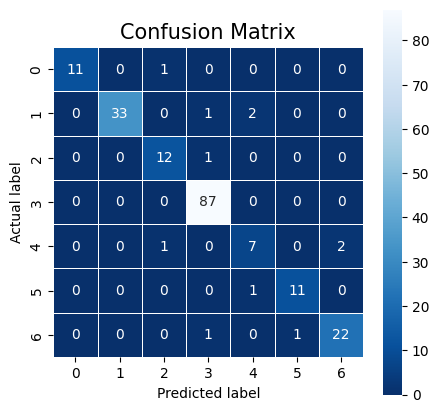

In [12]:
# Use the best model for face recognition
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size=15)# Classification report


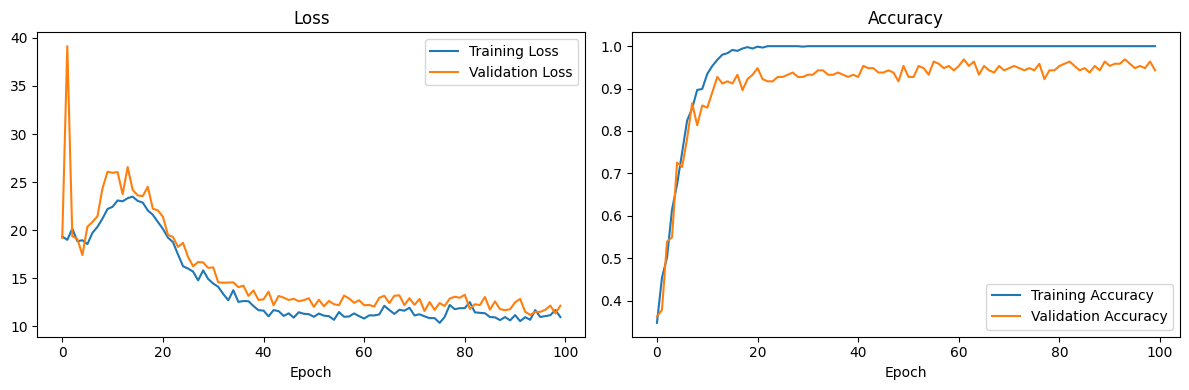

Classification Report:
                    precision    recall  f1-score   support

     Ariel Sharon       1.00      0.92      0.96        12
     Colin Powell       1.00      0.92      0.96        36
  Donald Rumsfeld       0.86      0.92      0.89        13
    George W Bush       0.97      1.00      0.98        87
Gerhard Schroeder       0.70      0.70      0.70        10
      Hugo Chavez       0.92      0.92      0.92        12
       Tony Blair       0.92      0.92      0.92        24

         accuracy                           0.94       194
        macro avg       0.91      0.90      0.90       194
     weighted avg       0.94      0.94      0.94       194



In [13]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_cnn_history.history['loss'], label='Training Loss')
plt.plot(best_cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(best_cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_classes, target_names=target_names))



